#Large-scale prediction using Spark

Load and broadcast the saved model, then use a Pandas UDF to score images on worker nodes.

If you use an autoscaling cluster with minimum worker of nodes = 0, the first Spark command will block for around 10 minutes while the worker node(s) are provisioned.

# Imports

In [3]:
import numpy as np
import random
import tensorflow as tf
import math
import io
import sys

from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import col, expr, arrays_zip, pandas_udf, explode, posexplode
import pandas as pd

from distutils.version import StrictVersion
from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

# Add library path to TensorFlow object detection module
sys.path.append("/opt/tensorflow/models/research")
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

# Model preparation

In [5]:
PATH_TO_SAVED_MODEL = '/dbfs/object_detection/inception/inference_graph/saved_model'
PATH_TO_LABELS = '/dbfs/object_detection/inception/data/pet_label_map.pbtxt'

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `beagle`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def sample_spark_data_frame_rows(df, n):
  count = df.count()
  frac = (n+1)/count # Add 1 row to circumvent rounding errors
  return df.sample(fraction = frac if frac <= 1 else 1, seed=1).limit(n)

#Distributed prediction

Load and broadcast the saved model to worker nodes. We import the model created by running `export_inference_graph.py` in a previous notebook.

In [11]:
sess = tf.Session()
model = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], PATH_TO_SAVED_MODEL)
bc_model = sc.broadcast(model)
sess.close()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.

Read validation image dataset (TFRecord fileset created by running `create_pet_tf_record.py` in a previous notebook) and display the first record from the dataset.

In [13]:
schema = StructType([
  StructField("image/filename", StringType()),
  StructField("image/format", StringType()),
  StructField("image/height", IntegerType()),
  StructField("image/object/bbox/xmax", ArrayType(FloatType())),
  StructField("image/object/bbox/xmin", ArrayType(FloatType())),
  StructField("image/object/bbox/ymax", ArrayType(FloatType())),
  StructField("image/object/bbox/ymin", ArrayType(FloatType())),
  StructField("image/object/class/label", ArrayType(IntegerType())), 
  StructField("image/object/class/text", ArrayType(StringType())),
  StructField("image/object/difficult", ArrayType(IntegerType())),
  StructField("image/object/truncated",ArrayType(IntegerType())),
  StructField("image/object/view", ArrayType(StringType())),
  StructField("image/source_id", StringType()),
  StructField("image/width", IntegerType()),
  StructField('image/encoded', BinaryType()),
])

df = spark.read.format("tfrecords").schema(schema).load('/object_detection/inception/data/pet_faces_val.record-*').cache()
for field in df.schema.fields:
  if isinstance(field.dataType, ArrayType):
    df = df.withColumn(field.name, expr("`%s`[0]" % field.name))
df.limit(1).toPandas().T

Out[27]: 
 0
image/filename pomeranian_149.jpg
image/format jpeg
image/height 225
image/object/bbox/xmax 0.596667
image/object/bbox/xmin 0.333333
image/object/bbox/ymax 0.56
image/object/bbox/ymin 0.133333
image/object/class/label 25
image/object/class/text pomeranian
image/object/difficult 0
image/object/truncated 0
image/object/view Frontal
image/source_id pomeranian_149.jpg
image/width 300
image/encoded [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...

Define the Pandas scalar mapping function (`predict_batch`) running our deep neural network model. It receives a Series of image records and returns multiple Series with the detection scores, classes etc. from the model. You can increase the `batch_size`, `num_parallel_calls` and `prefetch` parameters depending on your worker node configuration (number of GPUs and memory available).

Pandas Scalar UDF can't return complex nested types because of limitations in Apache Arrow. Therefore we return multiple Series, and will reorganize the data structure later in Spark.

In [15]:
BOX_VARS = ['ymin', 'xmin', 'ymax', 'xmax']

def parse_image(image_data):
  image = tf.image.decode_jpeg(image_data, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.expand_dims(image, 0)
  image = tf.image.resize_bilinear(image, [300, 300],
                                       align_corners=False)
  image = tf.squeeze(image, [0])
  return image

#Define the function for model inference.
def predict_batch(image_batch, use_gpu=True):
  tf_config = None
  if not use_gpu:
    tf_config = tf.ConfigProto(device_count={'GPU': 0})
  
  with tf.Session(config=tf_config) as sess:

    batch_size = 4
    image_input = tf.placeholder(dtype=tf.string, shape=[None])
    dataset = tf.data.Dataset.from_tensor_slices(image_input)
    dataset = dataset.map(parse_image, num_parallel_calls=2).prefetch(8).batch(batch_size)
    iterator = dataset.make_initializable_iterator()
    image = iterator.get_next()

    tf.train.import_meta_graph(bc_model.value)

    ops = sess.graph.get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}
    for key in ['detection_boxes', 'detection_scores', 'detection_classes']:
      tensor_name = key + ':0'
      if tensor_name in all_tensor_names:
        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
            tensor_name)

    sess.run(tf.global_variables_initializer())
    sess.run(iterator.initializer, feed_dict={image_input: image_batch})

    result = defaultdict(list)
    try:
      while True: 
        batch = sess.run(image)
        output_dict = sess.run(tensor_dict, {'image_tensor:0': batch})
        # all outputs are float32 numpy arrays, so convert types as appropriate
        result['detection_classes'].extend(output_dict['detection_classes'].astype(int))
        # detection_boxes is an array of arrays, but Pandas Scalar UDF can't return complex nested types.
        #   As a workaround, return separate columns for the 4 coordinates.
        for b, var in enumerate(BOX_VARS):
          result['detection_boxes_%s' % var].extend([[box[b] for box in boxes] for boxes in output_dict['detection_boxes'] ])
        result['detection_scores'].extend(output_dict['detection_scores'])
    except tf.errors.OutOfRangeError:
      pass

    return pd.DataFrame(result)


In [16]:
#Test the function locally.
sample_image_batch = df.limit(2).toPandas().loc[:, "image/encoded"].apply(lambda x: bytes(x))
sample_image_batch_pred = predict_batch(sample_image_batch, use_gpu=False)
print(sample_image_batch_pred.shape)
sample_image_batch_pred.head(1).T

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(2, 6)
Out[29]: 
 0
detection_classes [30, 30, 30, 34, 36, 26, 6, 22, 25, 30, 34, 22...
detection_boxes_ymin [0.1864248, 0.21133721, 0.16793518, 0.20837307...
detection_boxes_xmin [0.25535718, 0.29697943, 0.3121951, 0.25160232...
detection_boxes_ymax [0.56925255, 0.5501989, 0.7796464, 0.52631956,...
detection_boxes_xmax [0.7132181, 0.5885515, 0.6416897, 0.6139661, 0...
detection_scores [0.14138582, 0.105966, 0.07868646, 0.06695639,...

Wrap our Pandas function into a Spark Pandas UDF, and apply the UDF to a sample of 1000 images from our Spark DataFrame.

In [18]:
schema = StructType([
    StructField("detection_classes", ArrayType(IntegerType())),
    StructField("detection_scores", ArrayType(DoubleType())),
    *[StructField("detection_boxes_%s" % var, ArrayType(DoubleType())) for var in BOX_VARS],
])

predict_batch_udf = pandas_udf(predict_batch, returnType=schema)

df_subset = sample_spark_data_frame_rows(df, 1000)
predictions_raw = df_subset.withColumn("detection_raw", predict_batch_udf(col("image/encoded"))).cache()
display(predictions_raw.select("detection_raw.detection_classes").limit(2))

detection_classes
"List(25, 25, 30, 32, 19, 30, 18, 32, 19, 18, 25, 27, 37, 25, 25, 7, 11, 5, 30, 20, 20, 11, 7, 31, 37, 21, 16, 18, 9, 33, 2, 3, 24, 23, 14, 17, 30, 3, 30, 13, 12, 36, 30, 17, 24, 16, 27, 6, 30, 16, 21, 5, 25, 20, 12, 31, 34, 3, 35, 26, 18, 22, 32, 32, 26, 1, 4, 26, 31, 32, 19, 10, 33, 2, 27, 7, 29, 23, 2, 35, 30, 5, 14, 18, 32, 8, 10, 6, 19, 28, 32, 30, 5, 7, 16, 37, 7, 32, 28, 1, 8, 19, 33, 1, 7, 27, 22, 29, 5, 18, 18, 13, 11, 12, 18, 5, 25, 5, 17, 17, 11, 35, 33, 24, 7, 4, 36, 20, 24, 21, 6, 31, 4, 24, 7, 27, 9, 31, 36, 11, 17, 3, 28, 1, 11, 5, 13, 23, 12, 28, 16, 20, 13, 21, 10, 37, 22, 6, 21, 5, 9, 19, 7, 37, 2, 23, 18, 13, 24, 36, 3, 23, 34, 11, 36, 15, 17, 33, 22, 8, 37, 29, 26, 13, 28, 28, 27, 8, 24, 37, 1, 25, 4, 36, 22, 31, 36, 13, 20, 16, 13, 26, 23, 37, 13, 14, 36, 16, 5, 4, 10, 12, 15, 12, 17, 18, 32, 32, 14, 16, 13, 23, 8, 15, 5, 3, 10, 9, 32, 17, 19, 22, 6, 12, 36, 33, 17, 26, 1, 4, 25, 2, 34, 8, 21, 33, 30, 7, 12, 13, 18, 17, 2, 29, 18, 27, 19, 12, 28, 23, 32, 9, 14, 28, 28, 9, 1, 27, 6, 27, 7, 26, 25, 30, 29, 24, 22, 11, 21, 4, 29, 15, 37, 32, 34, 34, 3, 14, 20, 34, 31, 2, 14, 11, 7, 8, 4, 32, 6, 11)"
"List(36, 17, 13, 31, 17, 36, 31, 37, 14, 14, 16, 20, 16, 23, 20, 19, 30, 23, 13, 31, 36, 18, 5, 30, 17, 7, 3, 17, 29, 17, 20, 26, 36, 16, 32, 13, 18, 19, 22, 2, 7, 6, 25, 32, 32, 24, 24, 24, 35, 28, 29, 15, 26, 12, 9, 1, 28, 37, 2, 3, 22, 15, 6, 17, 17, 12, 1, 8, 1, 23, 36, 12, 27, 15, 7, 6, 24, 16, 35, 13, 14, 27, 28, 8, 11, 20, 25, 24, 36, 16, 35, 3, 4, 14, 22, 19, 34, 27, 17, 25, 11, 4, 27, 37, 10, 28, 6, 8, 34, 11, 16, 18, 10, 37, 15, 37, 13, 20, 34, 33, 13, 12, 21, 5, 14, 25, 8, 19, 17, 5, 23, 33, 4, 33, 14, 17, 3, 17, 33, 8, 23, 21, 12, 31, 7, 15, 13, 31, 31, 5, 6, 9, 30, 16, 2, 10, 4, 15, 23, 4, 18, 14, 15, 20, 30, 17, 36, 31, 18, 29, 32, 17, 7, 5, 14, 7, 30, 17, 36, 21, 29, 37, 27, 8, 27, 20, 36, 37, 12, 24, 8, 32, 26, 21, 22, 29, 13, 26, 12, 19, 35, 33, 16, 28, 36, 23, 32, 36, 36, 13, 15, 7, 32, 28, 37, 15, 30, 9, 32, 13, 6, 14, 31, 18, 14, 23, 3, 5, 19, 11, 4, 2, 18, 22, 9, 18, 5, 12, 7, 18, 22, 1, 30, 19, 12, 16, 8, 24, 15, 3, 30, 30, 33, 6, 17, 17, 5, 2, 26, 34, 25, 3, 15, 7, 23, 4, 32, 37, 4, 24, 4, 21, 22, 26, 12, 4, 35, 21, 2, 28, 21, 9, 26, 7, 10, 9, 34, 28, 28, 3, 36, 34, 25, 28, 1, 5, 6, 34, 19, 27)"


## Post-processing prediction data

Spark collapses the Series returned by the UDF into a Spark `struct`. We unwrap the `struct` into multiple columns, and merge the 4 `detection_boxes_*` series (each with one coordinates of the detection bounding box) into an array of arrays. The order `(ymin, xmin, ymax, xmax)` is [by convention](https://github.com/tensorflow/models/blob/v1.12.0/research/object_detection/utils/visualization_utils.py#L643) in the TensorFlow Object Detection API.

In [21]:
predictions_cols = (predictions_raw
  .withColumn("detection_classes", expr("detection_raw.detection_classes"))
  .withColumn("detection_scores", expr("detection_raw.detection_scores"))
  .withColumn("detection_boxes", expr("""
  transform(
    arrays_zip(
      detection_raw.detection_boxes_ymin,
      detection_raw.detection_boxes_xmin,
      detection_raw.detection_boxes_ymax,
      detection_raw.detection_boxes_xmax
    ),
    x -> array(
      cast(x.detection_boxes_ymin * `image/height` as int),
      cast(x.detection_boxes_xmin * `image/width` as int),
      cast(x.detection_boxes_ymax * `image/height` as int),
      cast(x.detection_boxes_xmax * `image/width` as int)
    ))
    """)
  )
  .drop("detection_raw")
).cache()
predictions_cols.select("image/width", "image/height", "detection_classes", "detection_scores", "detection_boxes").limit(1).toPandas().T

Out[31]: 
 0
image/width 300
image/height 225
detection_classes [25, 25, 30, 32, 19, 30, 18, 32, 19, 18, 25, 2...
detection_scores [0.9822102785110474, 0.2992851436138153, 0.046...
detection_boxes [[22, 96, 124, 188], [0, 88, 138, 177], [33, 8...

Let's visualize our predictions on a few sample images.

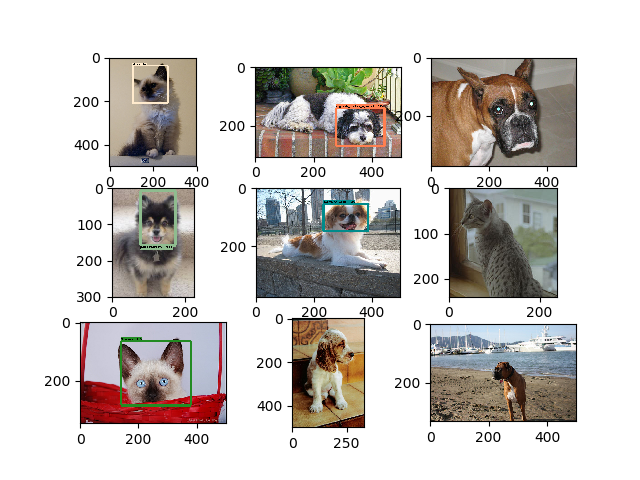

In [23]:
ncols = 3
ppred = sample_spark_data_frame_rows(predictions_cols, 9).toPandas()
fig, axes = plt.subplots(math.ceil(len(ppred) / ncols), ncols, squeeze=False)
for ax_idx, row in ppred.iterrows():
  col = ax_idx % ncols
  ax = axes[int((ax_idx - col)/ncols), col]
  image = Image.open(io.BytesIO(row['image/encoded']))
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      np.array(row['detection_boxes']),
      row['detection_classes'],
      row['detection_scores'],
      category_index,
      instance_masks=row.get('detection_masks'),
      use_normalized_coordinates=False,
      min_score_thresh=0.5,
      line_thickness=8)
  ax.imshow(image_np)
display(fig)

## Comparing predictions to ground truth

In this scenario, we want to compare the highest scoring prediction with the ground truth label, regardless of the prediction score. We use Spark `explode` function to expand each row (containing arrays of 100 predictions) into 100 rows each, then filtering for the first row (since the Oxford Pet data set only contains one animal per image).

If you expect multiple object detections and/or want to measure model accuracy, you could filter predictions with a score of at least 0.5, but you will need additional logic to account for false negatives.

In [26]:
predictions_exploded = (predictions_cols
  .selectExpr("*", "posexplode(arrays_zip(detection_classes, detection_scores, detection_boxes)) AS (detection_num, col)")
  .withColumn("detection_class", expr("col.detection_classes"))
  .withColumn("detection_score", expr("col.detection_scores"))
  .withColumn("detection_box", expr("col.detection_boxes"))
  .drop("col", "detection_classes", "detection_scores", "detection_boxes")
  .filter(expr("detection_num = 0"))
).cache()
display(predictions_exploded.drop("image/encoded").limit(5))

image/filename,image/format,image/height,image/object/bbox/xmax,image/object/bbox/xmin,image/object/bbox/ymax,image/object/bbox/ymin,image/object/class/label,image/object/class/text,image/object/difficult,image/object/truncated,image/object/view,image/source_id,image/width,detection_num,detection_class,detection_score,detection_box
pomeranian_149.jpg,jpeg,225,0.5966667,0.33333334,0.56,0.13333334,25,pomeranian,0,0,Frontal,pomeranian_149.jpg,300,0,25,0.9822102785110474,"List(22, 96, 124, 188)"
wheaten_terrier_173.jpg,jpeg,500,0.7909091,0.4090909,0.498,0.268,36,wheaten_terrier,0,0,Frontal,wheaten_terrier_173.jpg,330,0,36,0.8562948703765869,"List(133, 149, 265, 270)"
wheaten_terrier_143.jpg,jpeg,500,0.70933336,0.23466666,0.462,0.17,36,wheaten_terrier,0,0,Frontal,wheaten_terrier_143.jpg,375,0,36,0.9662514925003052,"List(105, 105, 227, 267)"
Persian_13.jpg,jpeg,375,0.986,0.146,0.73066664,0.0026666666,24,Persian,0,0,Frontal,Persian_13.jpg,500,0,27,0.580178439617157,"List(6, 98, 242, 495)"
Abyssinian_159.jpg,jpeg,201,0.3114754,0.0852459,0.33830845,0.05970149,1,Abyssinian,0,0,Frontal,Abyssinian_159.jpg,305,0,6,0.38043877482414246,"List(15, 30, 68, 95)"


We now join the predictions with our category names data.

In [28]:
categories = (spark.createDataFrame(Row(**x) for x in category_index.values())
            .withColumnRenamed("id", "category_id")
            .withColumnRenamed("name", "detection_category")
             )
predictions_named = (predictions_exploded     
     .join(categories, predictions_exploded.detection_class == categories.category_id, 'left')
     .select(predictions_exploded.columns + ["detection_category"])
    )
display(predictions_named.select("detection_category").limit(2))

detection_category
pug
pug


We now plot a confusion matrix representing the labels in the dataset vs. the predictions from our model.

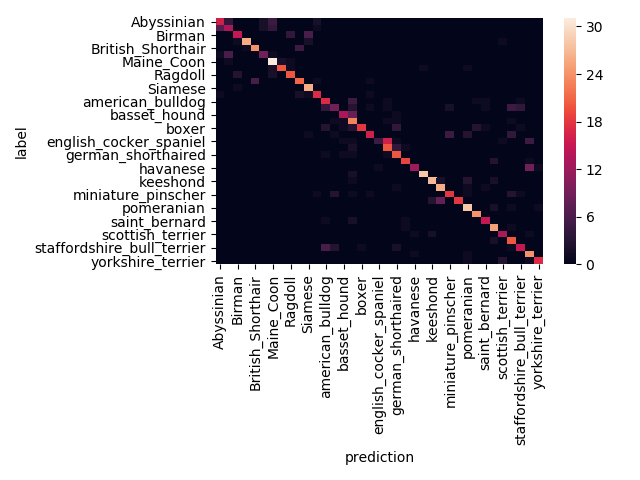

In [30]:
import seaborn as sns
ctdata = predictions_named.selectExpr("`image/object/class/text` as label", "detection_category as prediction").toPandas()
confusion_matrix = pd.crosstab(ctdata.label, ctdata.prediction)
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix)
fig.tight_layout()
display(fig)
